Success: uproot, vector, and awkward are loaded.
--- START OF H -> 4l ANALYSIS (Real Data) ---
Attempting to load a maximum of 1400000 events per file...
Step 1: Raw Data read OK
Diagnostic: Read 1400000 events. Number of Muons in the first event: 3
Step 2: Flatten OK
Step 3: ID OK
DEBUG: Type/Dtype of df['pt'].values: <class 'numpy.ndarray'> / float64
DEBUG: Type/Dtype of df['eta'].values: <class 'numpy.ndarray'> / float64
DEBUG: Type/Dtype of df['phi'].values: <class 'numpy.ndarray'> / float64
DEBUG: Type/Dtype of df['mass'].values: <class 'numpy.ndarray'> / float64
Success: 3308400 leptons loaded from DoubleMuon_B.
Step 1: Raw Data read OK
Diagnostic: Read 1400000 events. Number of Muons in the first event: 3
Step 2: Flatten OK
Step 3: ID OK
DEBUG: Type/Dtype of df['pt'].values: <class 'numpy.ndarray'> / float64
DEBUG: Type/Dtype of df['eta'].values: <class 'numpy.ndarray'> / float64
DEBUG: Type/Dtype of df['phi'].values: <class 'numpy.ndarray'> / float64
DEBUG: Type/Dtype of df['ma

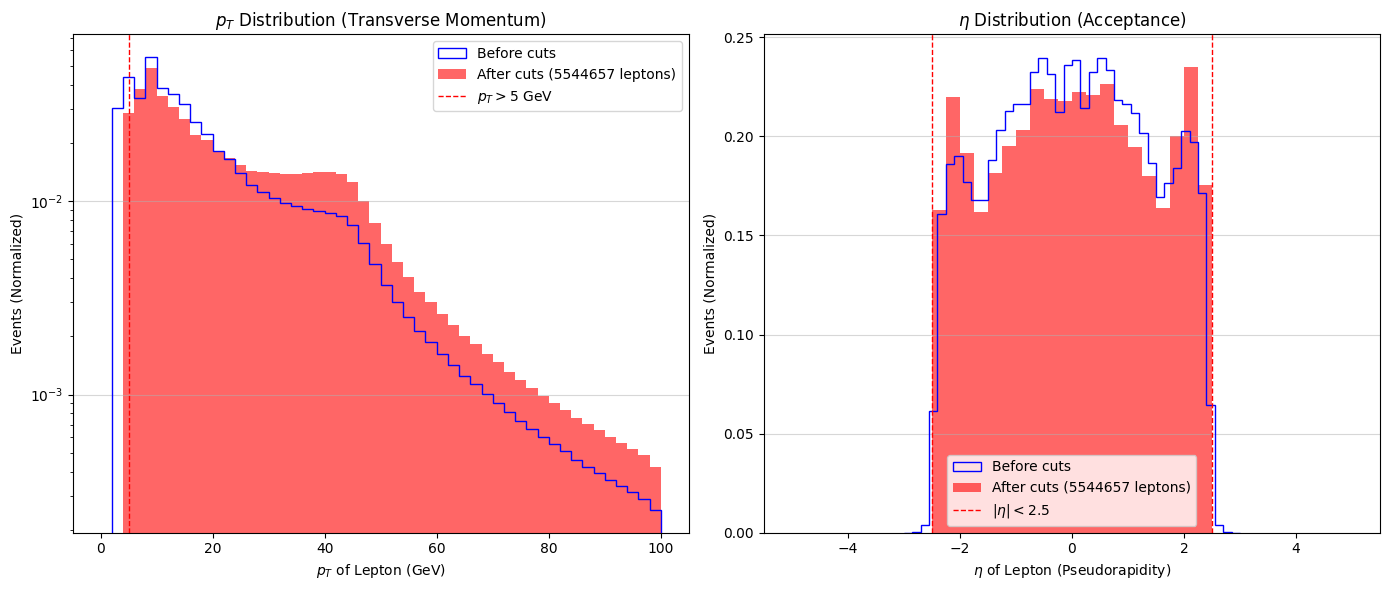


--- STATUS: Quality cuts applied and verified. ---

Preview of filtered leptons (ready for combination):
    event_id         pt  charge  flavor         iso
0  599701946  30.409157       1      13 -999.000000
1  599701946  33.029179       1      13 -999.000000
2  599721392  10.679796       1      13 -999.000000
3  599895577  56.900928       1      13    0.006498
4  599895577  34.670677      -1      13    0.000000

Step 5: Applying event-level filtering (4 leptons and zero net charge)...
Success: 'lv' column safely regenerated and re-attached to final candidates.
-> Initial Events: 3615782
-> Final Events (4l, net charge 0): 12037
-> Total Leptons remaining: 48148

--- STATUS: Event selection complete ---

Preview of H -> 4l candidate leptons:


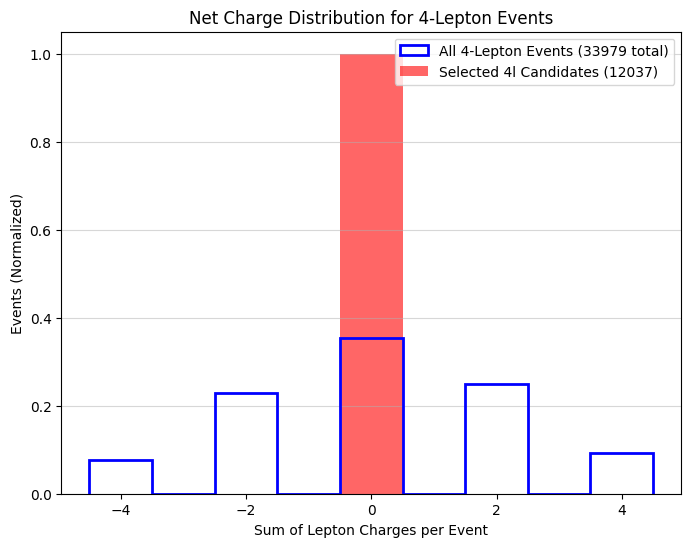

In [1]:
%run ../3_Charge_Selection/main.ipynb

In [ ]:
from itertools import combinations
Z_MASS = 91.1876
def find_z_candidates(df):
    """
    Trouve les candidats Z1 et Z2 en utilisant les vecteurs Lorentz (df['lv']).
    C'est ici que le calcul M4l est effectué.
    """
    z_candidates = []
    df_lite = df.drop(columns=['lv']) if 'lv' in df.columns else df
    
    df_lite['original_index'] = df_lite.index
    
    grouped = df_lite.groupby('event_id')
    
    for event_id, leptons_in_event in grouped:
        
        sfos_pairs = []
        
        # 1. Trouver toutes les paires SFOS
        i=0
        for l1_idx, l2_idx in combinations(leptons_in_event.index, 2):
            l1 = leptons_in_event.loc[l1_idx]
            l2 = leptons_in_event.loc[l2_idx]
            print(l1['flavor'], l2['flavor'], l1['charge'], l2['charge'])
            i=i+1
            
            # Condition SFOS (Same Flavor, Opposite Sign)
            if (l1['flavor'] == l2['flavor']) and (l1['charge'] * l2['charge'] < 0):

                try:
                    l1_lv = df.loc[l1_idx, 'lv']
                    l2_lv = df.loc[l2_idx, 'lv']
                    # Utilisation de l'addition de vecteurs Lorentz 
                    l_pair = l1_lv + l2_lv
                    m_inv = l_pair.mass
                except Exception as e:
                    # En cas d'erreur de calcul (racine carrée d'un nombre négatif)
                    continue 

                # Nettoyage des NaN ou Inf provenant de l'addition de vecteurs
                if not np.isfinite(m_inv):
                    continue

                sfos_pairs.append({
                    'mass': m_inv,
                    'l1_idx': l1_idx,
                    'l2_idx': l2_idx,
                    'abs_diff_z': np.abs(m_inv - Z_MASS) # Critère Z1
                })
        
        if len(sfos_pairs) < 2:
            continue 

        # 2. Sélectionner le candidat Z1 (le plus proche de M_Z)
        sfos_pairs.sort(key=lambda x: x['abs_diff_z'])
        z1_candidate = sfos_pairs[0]
        
        used_indices = {z1_candidate['l1_idx'], z1_candidate['l2_idx']}

        # 3. Sélectionner le candidat Z2 (Orthogonalité avec Z1)
        # used_indices = {z1_candidate['l1_idx'], z1_candidate['l2_idx']}
        # z2_candidate = None
        
        # for pair in sfos_pairs[1:]:
        #     # Z2 ne doit pas partager de lepton avec Z1 (Orthogonalité)
        #     if pair['l1_idx'] not in used_indices and pair['l2_idx'] not in used_indices:
        #         z2_candidate = pair
        #         break

         # --- DÉBUT DE LA SÉLECTION OPTIMALE Z2 ---
        
        best_z1_combo = None
        min_total_diff = np.inf
        
        # Itérer sur TOUTES les paires SFOS restantes pour trouver le meilleur Z2
        for pair_z2 in sfos_pairs:
            
            # Z2 ne doit pas partager de lepton avec Z1 (Orthogonalité)
            z2_indices = {pair_z2['l1_idx'], pair_z2['l2_idx']}
            if len(used_indices.intersection(z2_indices)) == 0:
                
                # Calculer la métrique d'optimisation (Minimiser |M_Z1 - M_Z| + |M_Z2 - M_Z|)
                current_total_diff = z1_candidate['abs_diff_z'] + pair_z2['abs_diff_z']
                
                # Cette condition est essentielle: Z2 doit être moins massif que Z1, ou la seconde meilleure.
                # L'analyse ATLAS/CMS est subtile. Si Z1 est trouvé, on cherche la meilleure paire
                # orthogonale restante qui minimise l'écart total (D).
                
                if current_total_diff < min_total_diff:
                    min_total_diff = current_total_diff
                    best_z1_combo = {
                        'z1': z1_candidate,
                        'z2': pair_z2
                    }

                
        if best_z1_combo:

            z1_candidate = best_z1_combo['z1']
            z2_candidate = best_z1_combo['z2']
            
            # Récupérer les 4 vecteurs Lorentz des leptons
            l1_lv = df.loc[z1_candidate['l1_idx'], 'lv']
            l2_lv = df.loc[z1_candidate['l2_idx'], 'lv'] 
            l3_lv = df.loc[z2_candidate['l1_idx'], 'lv']
            l4_lv = df.loc[z2_candidate['l2_idx'], 'lv']
            
            # Calcul de la masse du Higgs (M4l)
            h_lv = l1_lv + l2_lv + l3_lv + l4_lv
            h_mass = h_lv.mass
            
            if not np.isfinite(h_mass):
                continue
            
            z_candidates.append({
                'event_id': event_id,
                'z1_mass': z1_candidate['mass'],
                'z2_mass': z2_candidate['mass'],
                'h_mass': h_mass, 
                'l_indices': list(used_indices) + [z2_candidate['l1_idx'], z2_candidate['l2_idx']]
            })

    z_df = pd.DataFrame(z_candidates)
    
    print(f"\nTotal des événements avec au moins deux paires SFOS (Z1+Z2) : {len(z_df)}")
    return z_df

In [3]:
def plot_higgs_mass(z_boson_df):
    """ Affiche la distribution finale de la masse invariante M4l. """
    if z_boson_df.empty:
        print("Diagnostic : Le DataFrame des candidats Z est vide, impossible de tracer la masse du Higgs.")
        return
        
    print("\n--- STATUT : Candidats Z et masse du Higgs ($M_{4l}$) calculés. ---")
    print("\nAperçu des événements candidats Higgs :")
    print(z_boson_df[['event_id', 'z1_mass', 'z2_mass', 'h_mass']].head())

    # Affichage de l'histogramme de la masse invariante du Higgs
    plt.figure(figsize=(10, 6))
    plt.hist(z_boson_df['h_mass'], bins=20, range=(100, 150), color='skyblue', edgecolor='black', alpha=0.7, label='$M_{4\ell}$ Distribution')
    
    # Ligne de référence pour la masse connue du Higgs (125 GeV)
    plt.axvline(125.09, color='red', linestyle='--', linewidth=2, label='$M_H \\approx 125.1$ GeV') 

    plt.title('Distribution de la Masse Invariante $M_{4\ell}$ (Candidats Higgs)')
    plt.xlabel('Masse Invariante $M_{4\ell}$ (GeV)')
    plt.ylabel("Nombre d'Événements")
    plt.legend()
    plt.grid(axis='y', alpha=0.5)
    plt.show() 

    print(f"\nHistogramme de la masse invariante du Higgs (M_4l) généré pour {len(z_boson_df)} événements.")
    print("\nAnalyse terminée. Interprétez cet histogramme pour le pic de signal.")

<>:13: SyntaxWarning: invalid escape sequence '\e'
<>:18: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\e'
<>:13: SyntaxWarning: invalid escape sequence '\e'
<>:18: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_5400/2501924580.py:13: SyntaxWarning: invalid escape sequence '\e'
  plt.hist(z_boson_df['h_mass'], bins=20, range=(100, 150), color='skyblue', edgecolor='black', alpha=0.7, label='$M_{4\ell}$ Distribution')
/tmp/ipykernel_5400/2501924580.py:18: SyntaxWarning: invalid escape sequence '\e'
  plt.title('Distribution de la Masse Invariante $M_{4\ell}$ (Candidats Higgs)')
/tmp/ipykernel_5400/2501924580.py:19: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('Masse Invariante $M_{4\ell}$ (GeV)')


In [4]:
def add_lorentz_vectors(df):
    """ Ajoute la colonne 'lv' (Lorentz Vector) au DataFrame. """
    if df.empty:
        return df
        
    # S'assurer que les données sont des arrays NumPy (requis par vector.array)
    pt_data = df['pt'].to_numpy(dtype=np.float64)
    eta_data = df['eta'].to_numpy(dtype=np.float64)
    phi_data = df['phi'].to_numpy(dtype=np.float64)
    mass_data = df['mass'].to_numpy(dtype=np.float64)
    
    # Utilisation de vector.array() pour créer l'objet qui fonctionne
    vector_array_temp = vector.array({
        "pt": pt_data, 
        "eta": eta_data, 
        "phi": phi_data, 
        "mass": mass_data
    })
    
    df['lv'] = vector_array_temp
    return df

13.0 13.0 -1.0 1.0
candidate
MomentumObject4D(pt=44.96112823486328, phi=-1.6332749128341675, eta=-0.8948259949684143, mass=0.10565836727619171)


13.0 13.0 -1.0 -1.0
13.0 13.0 -1.0 1.0
candidate
MomentumObject4D(pt=44.96112823486328, phi=-1.6332749128341675, eta=-0.8948259949684143, mass=0.10565836727619171)
13.0 13.0 1.0 -1.0
candidate
MomentumObject4D(pt=18.586368560791016, phi=-3.0658695697784424, eta=0.5027053356170654, mass=0.10565836727619171)
13.0 13.0 1.0 1.0
13.0 13.0 -1.0 1.0
candidate
MomentumObject4D(pt=46.61912536621094, phi=-1.627957820892334, eta=-0.8770994544029236, mass=0.10565836727619171)
13.0 13.0 1.0 -1.0
candidate
MomentumObject4D(pt=12.767714500427246, phi=-0.2663106918334961, eta=-0.007491892669349909, mass=0.10565836727619171)
13.0 13.0 1.0 -1.0
candidate
MomentumObject4D(pt=12.767714500427246, phi=-0.2663106918334961, eta=-0.007491892669349909, mass=0.10565836727619171)
13.0 13.0 1.0 1.0
13.0 13.0 -1.0 -1.0
13.0 13.0 -1.0 1.0
candidate
MomentumObject4D(pt=32.19273376464844, phi=0.04319377243518829, eta=-0.21812546253204346, mass=0.10565836727619171)
13.0 13.0 -1.0 1.0
candidate
MomentumObject4D(pt=31.83

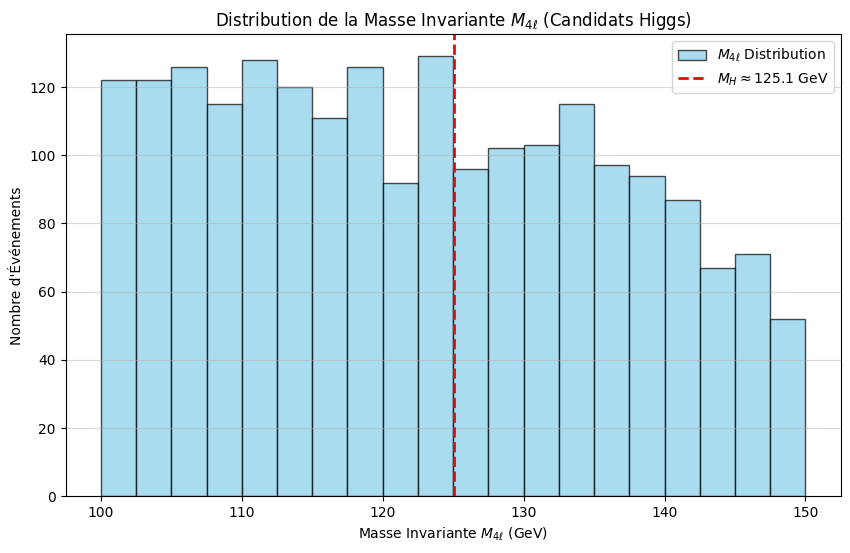


Histogramme de la masse invariante du Higgs (M_4l) généré pour 11946 événements.

Analyse terminée. Interprétez cet histogramme pour le pic de signal.


In [5]:
#four_lepton_candidates_df, all_four_leptons_df

# 1. Nettoyage final et ajout des vecteurs Lorentz
cleaned_candidates_df = four_lepton_candidates_df
#higgs_leptons_df = add_lorentz_vectors(cleaned_candidates_df)

higgs_leptons_df = cleaned_candidates_df

# 2. Exécuter la sélection Z1 et Z2, et calculer la masse du Higgs (M4l)
z_boson_df = find_z_candidates(higgs_leptons_df)

# 3. Afficher le résultat final
print("\n--- Aperçu des Candidats Higgs (Z1, Z2, M4l) ---")
if not z_boson_df.empty:
    print(z_boson_df[['event_id', 'z1_mass', 'z2_mass', 'h_mass']].head())
    
    # Appeler la fonction de tracé (si vous l'avez ajoutée)
    plot_higgs_mass(z_boson_df) 
else:
    print("Aucun événement H -> 4l n'a passé la sélection Z1 + Z2.")
